# Section 2.2.2: Weibull Time-to-Event Prediction Model Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement the Weibull time-to-event prediction model (Example 2.2.3 in Section 2.2.2 of the monograph) as a PyTorch model. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail. In this follow-up Weibull time-to-event prediction model demo, we mainly only explain steps that are different from the earlier exponential time-to-event prediction model demo.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up a Weibull time-to-event prediction model

In the monograph, right after equation (2.14), we state that the Weibull model corresponds to having shape parameter $e^\phi$ and scale parameter $\exp(-\beta^\top x - \psi e^{-\phi})$. In other words:

- The log shape is given by $\phi$.
- The log scale is given by $-\beta^\top x - \psi e^{-\phi}$.

We shall implement the Weibull model using `nn.Module`, where the `forward` function outputs a 2D table (rows correspond to different data points, and there are two columns where column 0 stores log scale, and column 1 stores log shape). The reason that we specify the `forward` function in this manner is that we will use the built-in `torchsurv` Weibull loss function, which expects the output of the neural network (i.e., the output of the `forward` function) to be of the format we just stated.

In [4]:
import torch.nn as nn

torch.manual_seed(0)

class WeibullTimeToEventModel(nn.Module):
    def __init__(self, num_input_features):
        super(WeibullTimeToEventModel, self).__init__()

        # randomly initialize parameters phi and psi to be close to 0
        self.phi = nn.Parameter(.01*torch.randn(1, dtype=torch.float))
        self.psi = nn.Parameter(.01*torch.randn(1, dtype=torch.float))

        # to randomly initialize the inner product weights (called beta in the
        # monograph), we just construct a nn.Linear object as to output a single
        # real number and we do not use a bias
        self.linear = nn.Linear(num_input_features, 1, bias=False)

    def forward(self, inputs):
        # we output log scale and log shape values since these are what torchsurv's
        # Weibull negative log likelihood loss function expects as the output of the
        # base neural network

        batch_size = inputs.size(0)

        # column 0 stores log scale, column 1 stores log shape
        log_params = torch.zeros(batch_size, 2, dtype=torch.float, device=inputs.device)

        log_params[:, 1] = self.phi  # set all log shape values to be the same
        log_params[:, 0] = (-self.linear(inputs) - self.psi*((-self.phi).exp())).view(-1)
        return log_params

num_input_features = X_train.size(1)
weibull_model = WeibullTimeToEventModel(num_input_features).to(device)

Right now the parameters have been randomly initialized as follows:

In [5]:
weibull_model.linear.weight  # this is what is called beta in the monograph in equation (2.12)

Parameter containing:
tensor([[-0.0884,  0.0615, -0.0045,  0.1819, -0.0204,  0.0607, -0.0693, -0.0451,
         -0.2192, -0.1519, -0.0946,  0.0085,  0.0907,  0.1377, -0.1555, -0.0999,
          0.0833,  0.1905, -0.0472]], device='cuda:0', requires_grad=True)

In [6]:
weibull_model.phi  # this is what is called phi in the monograph in equation (2.12)

Parameter containing:
tensor([0.0154], device='cuda:0', requires_grad=True)

In [7]:
weibull_model.psi  # this is what is called psi in the monograph in equation (2.12)

Parameter containing:
tensor([-0.0029], device='cuda:0', requires_grad=True)

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [8]:
from copy import deepcopy
from torch.utils.data import DataLoader
from torchsurv.loss.weibull import neg_log_likelihood

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(weibull_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    weibull_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        log_hazards_batch = weibull_model(X_batch)
        loss_batch = neg_log_likelihood(log_hazards_batch, D_batch, Y_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    weibull_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            log_hazards_batch = weibull_model(X_batch)

            # some loss functions have a reduction argument that can be set to 'sum'
            # to sum instead of taking a mean
            train_loss += neg_log_likelihood(log_hazards_batch, D_batch, Y_batch,
                                             reduction='sum')

            num_points += X_batch.size(0)
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            log_hazards_batch = weibull_model(X_batch)
            val_loss += neg_log_likelihood(log_hazards_batch, D_batch, Y_batch,
                                           reduction='sum')
            num_points += X_batch.size(0)
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(weibull_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
weibull_model.load_state_dict(best_params)

Epoch 1 - train loss 5.28985595703125 - val loss 5.249753475189209
Epoch 2 - train loss 5.090078353881836 - val loss 5.026221752166748
Epoch 3 - train loss 5.007582664489746 - val loss 4.933909893035889
Epoch 4 - train loss 4.948873043060303 - val loss 4.869334697723389
Epoch 5 - train loss 4.906196594238281 - val loss 4.823058605194092
Epoch 6 - train loss 4.875294208526611 - val loss 4.789720058441162
Epoch 7 - train loss 4.853026390075684 - val loss 4.76551628112793
Epoch 8 - train loss 4.837011337280273 - val loss 4.748401165008545
Epoch 9 - train loss 4.825368881225586 - val loss 4.735917568206787
Epoch 10 - train loss 4.816295146942139 - val loss 4.726292610168457
Epoch 11 - train loss 4.8099493980407715 - val loss 4.7195634841918945
Epoch 12 - train loss 4.804684638977051 - val loss 4.713958263397217
Epoch 13 - train loss 4.800281524658203 - val loss 4.709559440612793
Epoch 14 - train loss 4.796895980834961 - val loss 4.706185817718506
Epoch 15 - train loss 4.793860912322998 - v

<All keys matched successfully>

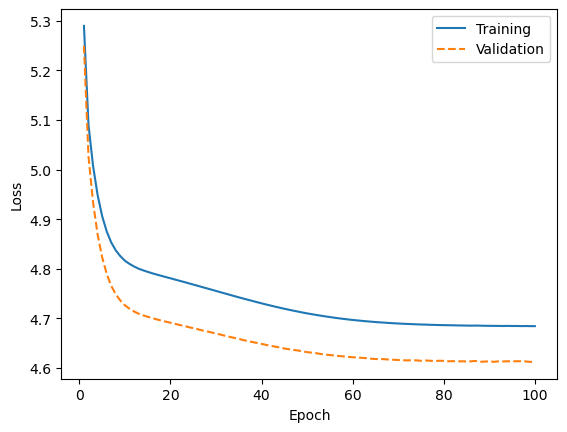

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the model, the model parameters are as follows:

In [10]:
weibull_model.linear.weight  # this is what is called beta in the monograph in equation (2.12)

Parameter containing:
tensor([[ 0.4742, -0.2208, -0.5639,  0.0936,  0.9127,  1.7130, -0.1796,  0.2298,
          0.0212, -0.0430,  0.0728, -0.0385,  0.1541, -0.7690, -1.4771, -1.3496,
         -1.5624, -1.3379, -1.6424]], device='cuda:0', requires_grad=True)

In [11]:
weibull_model.phi  # this is what is called phi in the monograph in equation (2.12)

Parameter containing:
tensor([-0.7233], device='cuda:0', requires_grad=True)

In [12]:
weibull_model.psi  # this is what is called psi in the monograph in equation (2.12)

Parameter containing:
tensor([-2.5321], device='cuda:0', requires_grad=True)

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [13]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor)

Next, we apply the neural net model to the test data. We convert the resulting log parameter values to NumPy arrays since the plotting and evaluation code later on does not need nor use PyTorch.

In [14]:
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
with torch.no_grad():
    log_params_test = weibull_model(X_test)
    log_params_test_np = log_params_test.cpu().numpy()

To back out a survival curve, for simplicity we just use a time grid specified by the unique times in the test data (this is not the only way to specify a time grid; for examples of other ways, see Section 2.3.2 of the monograph).

In [15]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)

# we now use equation (2.14) of the monograph applied to every test point
# (note that np.newaxis is used to replicate the time grid across data points
# and separately to replicate estimates parameters across time)
log_scales_test_np = log_params_test_np[:, 0]
log_shapes_test_np = log_params_test_np[:, 1]
surv_test_np = np.exp(-(time_grid_test_np[np.newaxis, :]
                        / log_scales_test_np[:, np.newaxis])**(np.exp(log_shapes_test_np)[:, np.newaxis]))

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

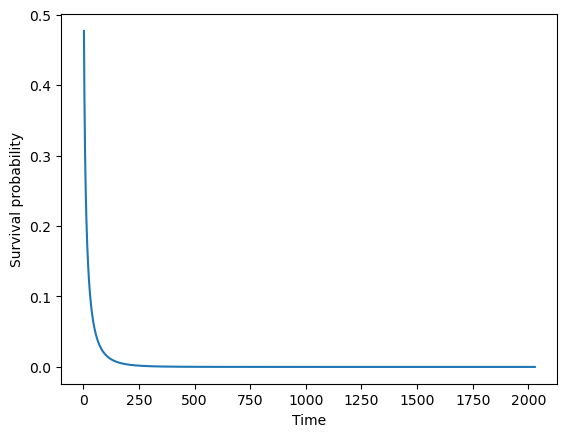

In [16]:
plt.plot(time_grid_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Concordance index (Harrell et al., 1982) using the scikit-survival implementation (Pölsterl, 2020)

Notice from equation (2.12) of the monograph that the Weibull time-to-event prediction model is a proportional hazards model, where the log partial hazard is precisely the negative log of the scale parameter. Thus, for Harrell's concordance index, we can treat the predicted negative log scales of the test data as the risk score estimates to rank the test data by.

In [17]:
from sksurv.metrics import concordance_index_censored

C_index = concordance_index_censored(D_test_np.astype(bool), Y_test_np, -log_scales_test_np.flatten())[0]
print(f"Harrell's concordance index: {C_index}")

Harrell's concordance index: 0.6030088460438192


#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [18]:
import pandas as pd
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6030088460438192


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [19]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5980416221583508
Eval time 693.0 - truncated time-dependent concordance: 0.603517430263355
Eval time 1291.0 - truncated time-dependent concordance: 0.6038200719271364


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [20]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6604852344197985
Eval time 693.0 - time-dependent AUC: 0.6929115660412561
Eval time 1291.0 - time-dependent AUC: 0.69878806226306


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [21]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.45454610237192405


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.36637116974695916
Eval time 1291.0 - Brier score: 0.29045614884455423
Integrated Brier score: 0.3053999453582976


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [22]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [23]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 649.8857943087481


In [24]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 768.3698620042896
